# Following article on Predicting Stock Prices
Article at: https://towardsdatascience.com/the-complete-guide-to-time-series-analysis-and-forecasting-70d476bfe775


In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error,r2_score
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from itertools import product
from tqdm import tqdm

In [2]:
data = pd.read_csv('stock_prices_sample.csv', index_col=['DATE'], parse_dates=['DATE'])
data

,TICKER,FIGI,TYPE,FREQUENCY,OPEN,HIGH,LOW,CLOSE,VOLUME,ADJ_OPEN,ADJ_HIGH,ADJ_LOW,ADJ_CLOSE,ADJ_VOLUME,ADJ_FACTOR,EX_DIVIDEND,SPLIT_RATIO
DATE,,,,,,,,,,,,,,,,,
2013-01-04,GEF,BBG000BLFQH8,EOD,daily,46.31,47.6198,46.23,47.37,248000.0,38.517220,39.606614,38.450681,39.398849,248000.0,NaN,0.0,1.0
2013-01-03,GEF,BBG000BLFQH8,EOD,daily,46.43,46.5200,46.14,46.48,131300.0,38.617027,38.691882,38.375826,38.658613,131300.0,NaN,0.0,1.0
2013-01-02,GEF,BBG000BLFQH8,EOD,daily,45.38,46.5400,45.16,46.41,184900.0,37.743715,38.708516,37.560735,38.600392,184900.0,NaN,0.0,1.0
2018-06-05,GF,BBG000C3C6S2,Intraday,daily,18.86,18.9100,18.87,18.87,10000.0,18.860000,18.910000,18.870000,18.870000,10000.0,NaN,0.0,1.0
2018-06-04,GF,BBG000C3C6S2,EOD,daily,18.86,18.8900,18.79,18.81,39095.0,18.860000,18.890000,18.790000,18.810000,39095.0,NaN,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-06-27,GF,BBG000C3C6S2,EOD,daily,18.63,18.6300,18.51,18.61,28400.0,11.717560,11.717560,11.642085,11.704981,28400.0,NaN,0.0,1.0
2014-06-26,GF,BBG000C3C6S2,EOD,daily,18.52,18.5901,18.42,18.53,60000.0,11.648374,11.692464,11.585478,11.654664,60000.0,NaN,0.0,1.0
2014-06-25,GF,BBG000C3C6S2,EOD,daily,18.66,18.7200,18.59,18.60,171700.0,11.736429,11.774167,11.692402,11.698691,171700.0,NaN,0.0,1.0


In [3]:
data['ADJ_FACTOR'].value_counts().sum()
#Only 7 rows out of 999 have values -> Useless attribute

7

### We only want stocks by GF (same source) and only looking at the End of Day (EOD) prices (consistent intervals)

In [4]:
data=data[data['TICKER']=='GF']
data=data[data['TYPE']=='EOD']

In [5]:
data

,TICKER,FIGI,TYPE,FREQUENCY,OPEN,HIGH,LOW,CLOSE,VOLUME,ADJ_OPEN,ADJ_HIGH,ADJ_LOW,ADJ_CLOSE,ADJ_VOLUME,ADJ_FACTOR,EX_DIVIDEND,SPLIT_RATIO
DATE,,,,,,,,,,,,,,,,,
2018-06-04,GF,BBG000C3C6S2,EOD,daily,18.86,18.8900,18.7900,18.8100,39095.0,18.860000,18.890000,18.790000,18.810000,39095.0,NaN,0.0,1.0
2018-06-01,GF,BBG000C3C6S2,EOD,daily,18.58,18.7600,18.5800,18.7400,17468.0,18.580000,18.760000,18.580000,18.740000,17468.0,NaN,0.0,1.0
2018-05-31,GF,BBG000C3C6S2,EOD,daily,18.52,18.5200,18.3012,18.4900,22384.0,18.520000,18.520000,18.301200,18.490000,22384.0,NaN,0.0,1.0
2018-05-30,GF,BBG000C3C6S2,EOD,daily,18.47,18.6780,18.4700,18.6500,22633.0,18.470000,18.678000,18.470000,18.650000,22633.0,NaN,0.0,1.0
2018-05-29,GF,BBG000C3C6S2,EOD,daily,18.51,18.5100,18.1500,18.2562,67412.0,18.510000,18.510000,18.150000,18.256200,67412.0,NaN,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-06-27,GF,BBG000C3C6S2,EOD,daily,18.63,18.6300,18.5100,18.6100,28400.0,11.717560,11.717560,11.642085,11.704981,28400.0,NaN,0.0,1.0
2014-06-26,GF,BBG000C3C6S2,EOD,daily,18.52,18.5901,18.4200,18.5300,60000.0,11.648374,11.692464,11.585478,11.654664,60000.0,NaN,0.0,1.0
2014-06-25,GF,BBG000C3C6S2,EOD,daily,18.66,18.7200,18.5900,18.6000,171700.0,11.736429,11.774167,11.692402,11.698691,171700.0,NaN,0.0,1.0


For simplicity lets remove the columns not directly related to closing price:

In [6]:
data.drop(['SPLIT_RATIO', 'EX_DIVIDEND', 'ADJ_FACTOR', 'ADJ_VOLUME', 'ADJ_CLOSE', 'ADJ_LOW', 'ADJ_HIGH', 'ADJ_OPEN', 'VOLUME', 'FREQUENCY', 'TYPE', 'FIGI']
         ,axis=1,inplace=True)
data

,TICKER,OPEN,HIGH,LOW,CLOSE
DATE,,,,,
2018-06-04,GF,18.86,18.8900,18.7900,18.8100
2018-06-01,GF,18.58,18.7600,18.5800,18.7400
2018-05-31,GF,18.52,18.5200,18.3012,18.4900
2018-05-30,GF,18.47,18.6780,18.4700,18.6500
2018-05-29,GF,18.51,18.5100,18.1500,18.2562
...,...,...,...,...,...
2014-06-27,GF,18.63,18.6300,18.5100,18.6100
2014-06-26,GF,18.52,18.5901,18.4200,18.5300
2014-06-25,GF,18.66,18.7200,18.5900,18.6000


## Basic EDA

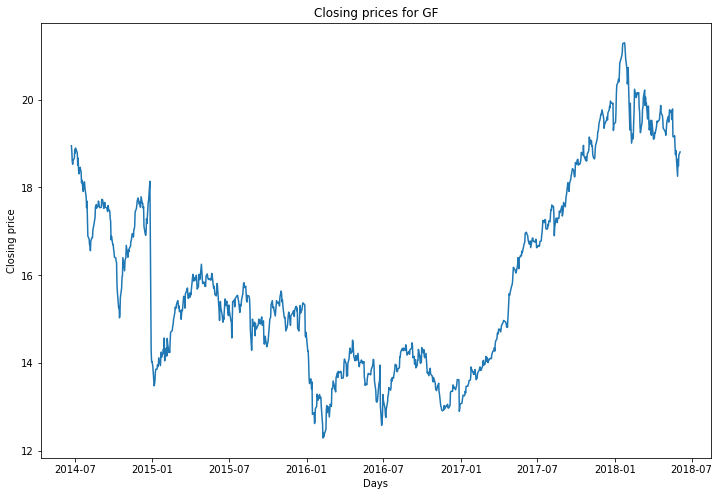

In [7]:
plt.figure(figsize=(12,8))
plt.plot(data['CLOSE'])
plt.title("Closing prices for GF")
plt.xlabel("Days")
plt.ylabel("Closing price")
plt.show()

## Observations:
1) Not stationary -  No constant Mean and Variance          
2) No clear seasonality - Not a periodic graph

# Try Moving Averages

In [8]:
def movingAvg(data,windowSize,plotError=False):
    
    movingaverage=data.rolling(windowSize).mean()
    r2=r2_score(data[windowSize:],movingaverage[windowSize:])
    
    plt.figure(figsize=(12,8))
    plt.plot(data[windowSize:],'b')
    plt.plot(movingaverage,'g')
    
    if plotError:
        mae = mean_absolute_error(data[windowSize:], movingaverage[windowSize:])
        sd = np.std(data[windowSize:] - movingaverage[windowSize:])
        lb = movingaverage-(mae+2*sd)
        ub = movingaverage+(mae+2*sd)
        plt.plot(ub, 'r--')
        plt.plot(lb, 'r--')
    
    plt.title(f"Moving average prices, {windowSize=}, r^2={r2}")
    plt.xlabel("Days")
    plt.ylabel("Closing price")
    plt.legend(['Moving average','Actual Data','Error'])
    plt.show()

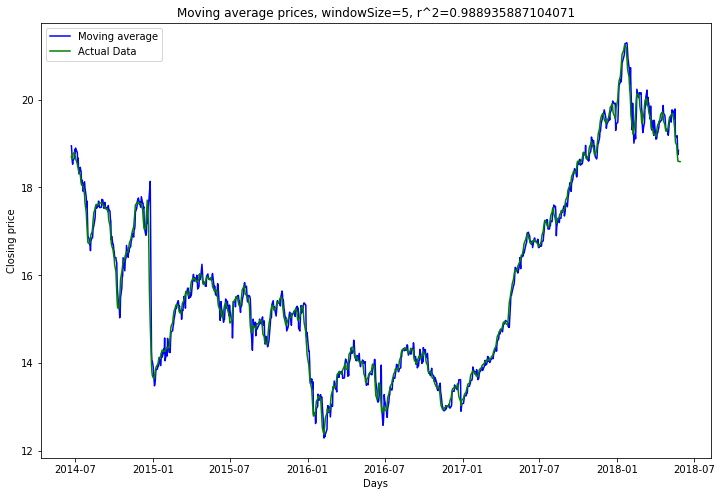

In [9]:
movingAvg(data['CLOSE'],5) # Using last 5 days

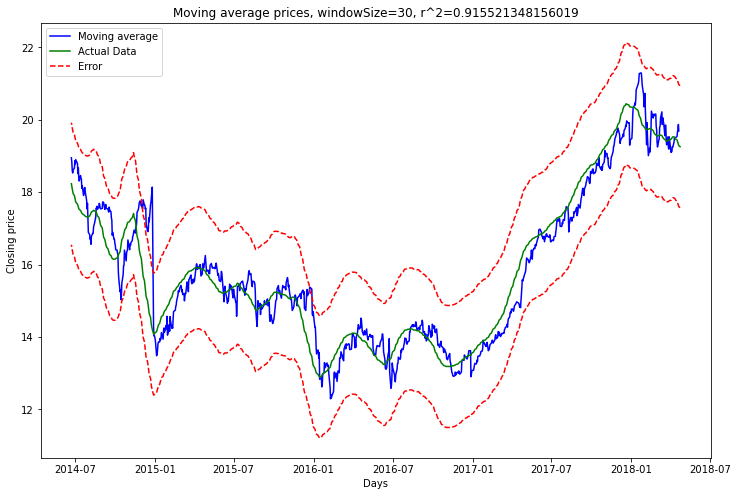

In [10]:
movingAvg(data['CLOSE'],30,plotError=True) # Using last 30 days

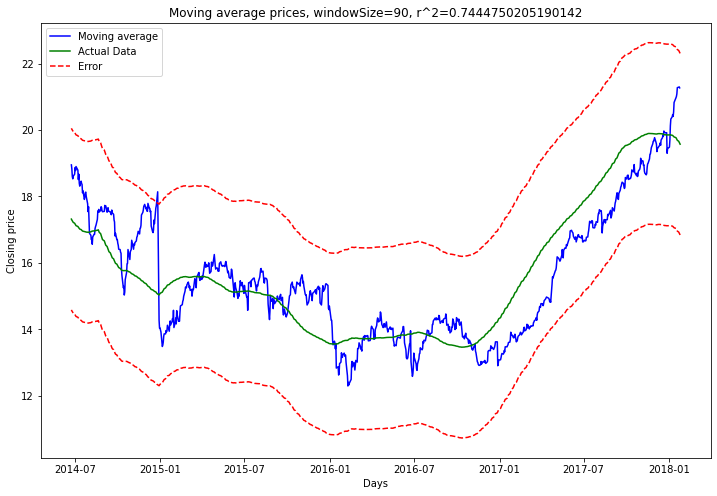

In [11]:
movingAvg(data['CLOSE'],90,plotError=True) # Using last 90 days

# Exponential Smoothing

In [12]:
def exponential_smoothing(data,alpha):
    ans=[data[0]]
    for n in range(1,len(data)):
        ans.append(alpha*data[n]+(1-alpha)*ans[n-1]) #Using the formula given
    r2=r2_score(data,ans)
    return ans,r2
  
def plot_exponential_smoothing(data,alphas):
 
    plt.figure(figsize=(12, 8))
    plt.plot(data.values, "b", label = "Real")
    for alpha in alphas:
        vals,r2=exponential_smoothing(data, alpha)
        plt.plot(vals, label=f"Alpha {alpha}, r^2={r2:0.3}")
    plt.xlabel("Days")
    plt.ylabel("Closing price")    
    plt.legend()
    plt.title(f"Exponential Smoothing")

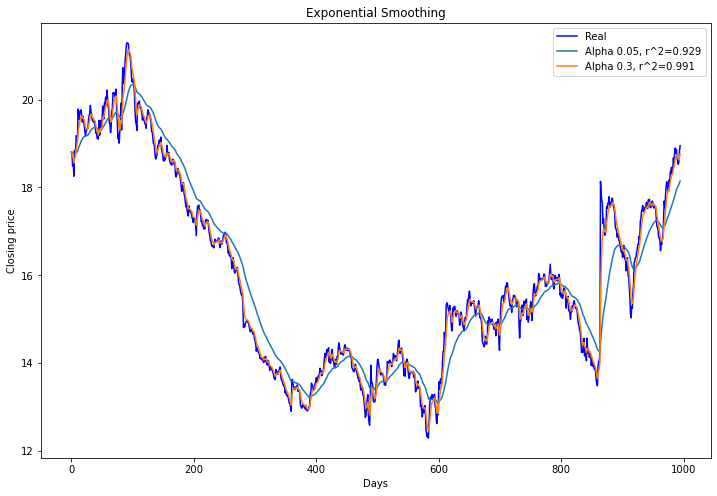

In [13]:
plot_exponential_smoothing(data['CLOSE'], [0.05, 0.3])

---------------------------------------------------

# Modelling as Stationary Process:
Stationary: Const Mean and Variance           
Use Dickey-Fuller test to see if its stationary already

In [14]:
def dickeyFullerPlot(data,lag=10):
    plt.figure(figsize=(12,8))
    p=sm.tsa.stattools.adfuller(data)[1]
    plt.title(f'Dickey-Fuller Plot, p={p}')
    plt.plot(data)
    plt.show()

In [15]:
def plotAutoCorr(data,lag=10):
    plt.figure(figsize=(12,8))
    ax=plt.subplot()
    smt.graphics.plot_acf(data, lags=lag, ax=ax)

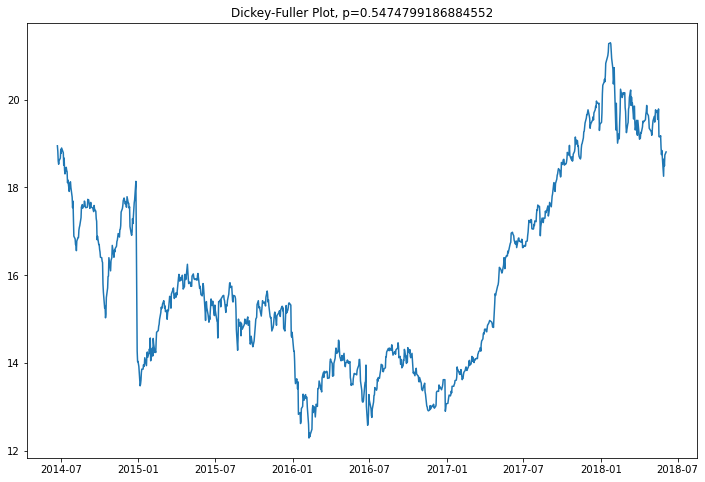

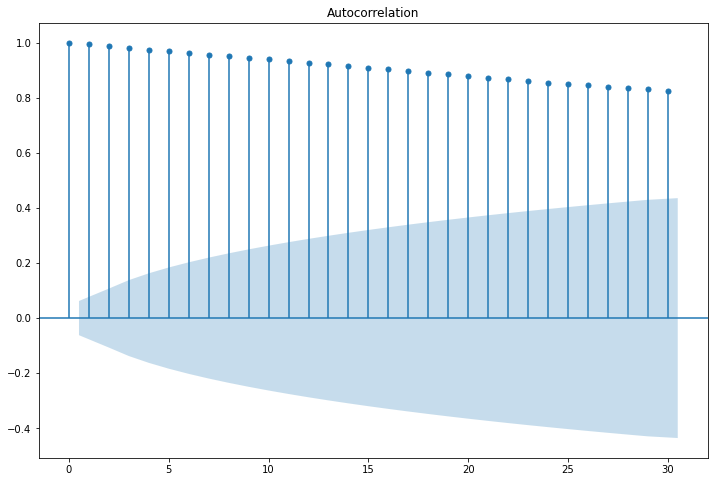

In [16]:
dickeyFullerPlot(data['CLOSE'],30)
plotAutoCorr(data['CLOSE'],30)

p>0.05, hence FTR -> data is NOT Stationary   
                 
Need to make it stationary:            
Consider change in prices rather than absolute prices. Lets consider change per day
           
            
              
AutoCorrelation plot shows very high values -> not seasonal data

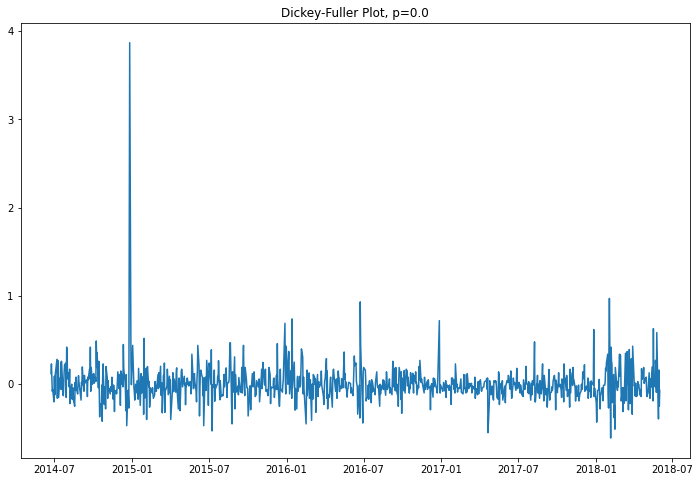

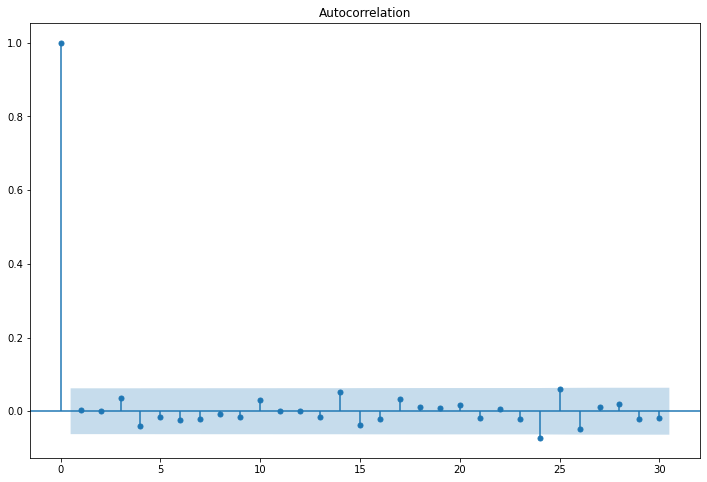

In [17]:
dataChangeInPrices=data['CLOSE'] - data['CLOSE'].shift(1)
dickeyFullerPlot(dataChangeInPrices[1:],30)
plotAutoCorr(dataChangeInPrices[1:],30)

p = 0.0 < 0.001 < 0.05 -> Reject H0 -> Data IS stationary             

Autoregression plot shows small values mostly, data is now seasonal

### Now we can try SARIMA

We shall vary values of the parameters (ps,d,qs,Ps,D,Qs,s) and try to find the best combo (Like gridsearch)

In [18]:
ps=range(0, 5)
qs=range(0, 5)
Ps=range(0, 5)
Qs=range(0, 5)

s,d,D=5,1,1

In [19]:
def getBestSARIMA(params,d,D,s): #d D s are constant based on the dataset
    #d - integration order, D - seasonal integration order, s - length of season
    res,bestAIC=[],np.Inf
    allparams=list(product(*params))
    for param in tqdm(allparams):
        try: 
            model = sm.tsa.statespace.SARIMAX(data['CLOSE'], order=(param[0], d, param[1]),seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:continue
        
        if model.aic<bestAIC:
            bestmodel=model
            bestAIC=model.aic
            bestparams=param
        res.append([param, model.aic])
        
    results=pd.DataFrame(res,columns=['Params','AIC'])
    results=results.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    return results

In [20]:
import warnings
warnings.filterwarnings('ignore')
bestres=getBestSARIMA((ps,qs,Ps,Qs),d,D,s)
bestres

100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [33:03<00:00,  3.17s/it]


,Params,AIC
0,"(0, 0, 2, 4)",-283.747685
1,"(0, 0, 3, 3)",-283.728320
2,"(0, 0, 2, 3)",-283.496324
3,"(0, 0, 0, 1)",-282.957730
4,"(0, 0, 3, 4)",-282.199883
...,...,...
620,"(4, 0, 0, 0)",389.879202
621,"(2, 1, 0, 0)",390.973503
622,"(1, 2, 0, 0)",390.995820
623,"(3, 1, 0, 0)",391.356520


In [63]:
p,q,P,Q = bestres['Params'][0] #Get the params of the model with the best (lowest) AIC
model = sm.tsa.statespace.SARIMAX(data['CLOSE'], order=(p,d,q),seasonal_order=(P,D,Q,s)).fit()
print(model.summary())

                                          SARIMAX Results                                           
Dep. Variable:                                        CLOSE   No. Observations:                  995
Model:             SARIMAX(0, 1, 0)x(2, 1, [1, 2, 3, 4], 5)   Log Likelihood                 148.874
Date:                                      Thu, 14 Jul 2022   AIC                           -283.748
Time:                                              18:41:34   BIC                           -249.471
Sample:                                                   0   HQIC                          -270.713
                                                      - 995                                         
Covariance Type:                                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L5       -0.5012      0.163  

In [64]:
preds=model.predict(0)
preds

DATE
2018-06-04     0.000000
2018-06-01    18.810000
2018-05-31    18.740000
2018-05-30    18.490000
2018-05-29    18.650000
                ...    
2014-06-27    18.690909
2014-06-26    18.601064
2014-06-25    18.568647
2014-06-24    18.604016
2014-06-23    18.852527
Name: predicted_mean, Length: 995, dtype: float64

In [65]:
data['CLOSE']

DATE
2018-06-04    18.8100
2018-06-01    18.7400
2018-05-31    18.4900
2018-05-30    18.6500
2018-05-29    18.2562
               ...   
2014-06-27    18.6100
2014-06-26    18.5300
2014-06-25    18.6000
2014-06-24    18.8300
2014-06-23    18.9500
Name: CLOSE, Length: 995, dtype: float64

In [66]:
r2_score(data['CLOSE'],preds.to_list())

0.8985438210176439